# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

Deep Learning for Coders with fastai & PyTorch de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the LICENSE file for details.

# Convolutional Neural Networks

In [1]:
from fastai2.vision.all import *

matplotlib.rc('image', cmap='Greys')

## The Magic of Convolutions

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

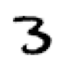

In [3]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [4]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [5]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [6]:
im3_t[4:7,10:13]

tensor([[  0,   0,   0],
        [155, 155, 155],
        [254, 254, 254]], dtype=torch.uint8)

In [7]:
im3_t[4:7,10:13] * top_edge

tensor([[ -0.,  -0.,  -0.],
        [  0.,   0.,   0.],
        [254., 254., 254.]])

In [8]:
(im3_t[4:7,10:13] * top_edge).sum()

tensor(762.)

In [9]:
im3_t[6:9,10:13]

tensor([[254, 254, 254],
        [189, 189, 150],
        [  0,   0,   0]], dtype=torch.uint8)

In [10]:
im3_t[6:9,10:13] * top_edge

tensor([[-254., -254., -254.],
        [   0.,    0.,    0.],
        [   0.,    0.,    0.]])

In [11]:
(im3_t[6:9,10:13] * top_edge).sum()

tensor(-762.)

In [12]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

In [13]:
apply_kernel(7,11,top_edge)

tensor(-762.)

### Mapping a Convolution Kernel

In [14]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

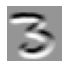

In [15]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

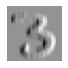

In [16]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

### Convolutions in PyTorch

In [17]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [18]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [19]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [20]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [21]:
edge_kernels = edge_kernels.unsqueeze(1)

In [22]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

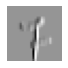

In [23]:
show_image(batch_features[0,0]);

### Strides and Padding

### Understanding the Convolution Equations

## Our First Convolutional Neural Network

### Creating the CNN

In [24]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [25]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [26]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

In [27]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [28]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [29]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [30]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [31]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [32]:
learn.summary()

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 14 x 14     40         True      
________________________________________________________________
ReLU                 64 x 4 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 8 x 7 x 7       296        True      
________________________________________________________________
ReLU                 64 x 8 x 7 x 7       0          False     
________________________________________________________________
Conv2d               64 x 16 x 4 x 4      1,168      True      
________________________________________________________________
ReLU                 64 x 16 x 4 x 4      0          False     
________________________________________________________________
Conv2d               64 x 32 x 2 x 2      4,640      True      
___________________________________________________

In [33]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.070947,0.055119,0.982336,00:07
1,0.026612,0.027653,0.991659,00:04


### Understanding Convolution Arithmetic

In [34]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [35]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [36]:
m[0].bias.shape

torch.Size([4])

### Receptive Fields

## Color Images

In [37]:
im = image2tensor(Image.open('ours.jpg'))
im.shape

torch.Size([3, 486, 729])

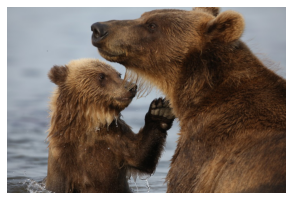

In [38]:
show_image(im);

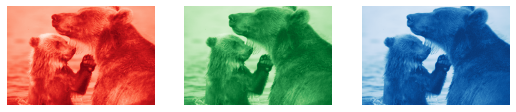

In [39]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

## Improving Training Stability

In [40]:
path = untar_data(URLs.MNIST)

In [41]:
path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [42]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

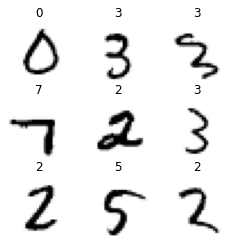

In [43]:
dls.show_batch(max_n=9, figsize=(4,4))

### A Simple Baseline

In [44]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [45]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [46]:
from fastai2.callback.hook import *

In [47]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn

In [48]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.306556,2.302432,0.113500,00:36


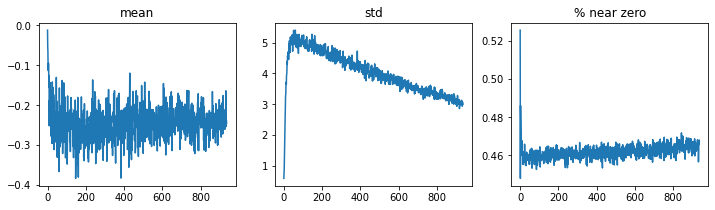

In [49]:
learn.activation_stats.plot_layer_stats(0)

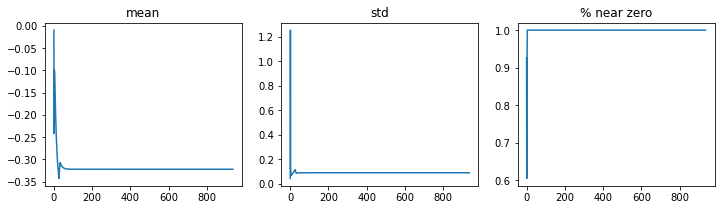

In [50]:
learn.activation_stats.plot_layer_stats(-2)

### Increase Batch Size

In [51]:
dls = get_dls(512)

In [52]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.375814,2.302550,0.113500,00:25


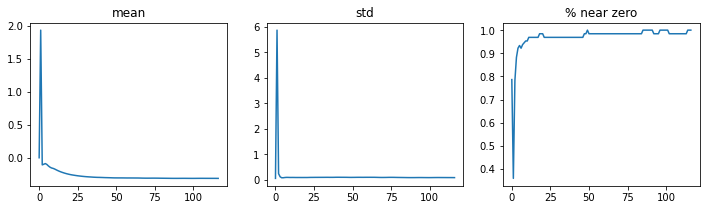

In [53]:
learn.activation_stats.plot_layer_stats(-2)

### 1cycle Training

In [54]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [55]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.204251,0.075319,0.977100,00:19


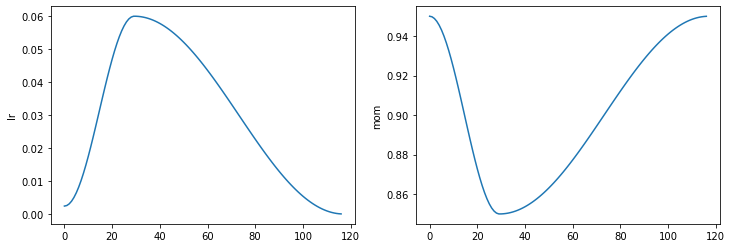

In [56]:
learn.recorder.plot_sched()

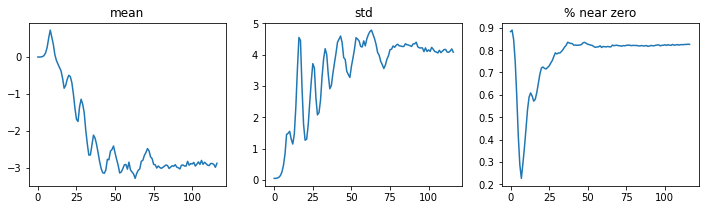

In [57]:
learn.activation_stats.plot_layer_stats(-2)

In [58]:
matplotlib.rc('image', cmap='viridis')

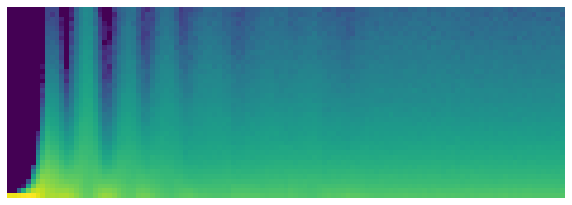

In [59]:
learn.activation_stats.color_dim(-2)

### Batch Normalization

In [60]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [61]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.134934,0.059084,0.986500,00:23


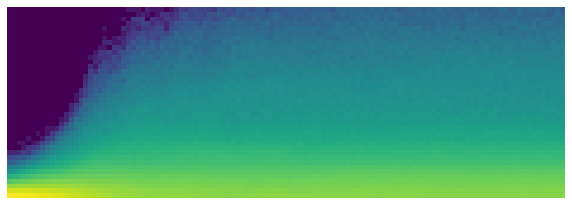

In [62]:
learn.activation_stats.color_dim(-4)

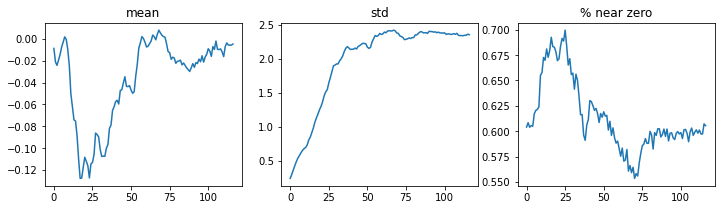

In [63]:
learn.activation_stats.plot_layer_stats(-2)

In [64]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.180495,0.170697,0.947800,00:23
1,0.078505,0.131177,0.955100,00:23
2,0.052498,0.053497,0.984200,00:22
3,0.030952,0.028283,0.991600,00:22
4,0.016275,0.022729,0.992300,00:23


In [65]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.193479,0.286997,0.919200,00:24
1,0.078824,0.072746,0.978200,00:22
2,0.051693,0.046122,0.984600,00:22
3,0.032718,0.035554,0.989000,00:24
4,0.016139,0.025272,0.991400,00:23


# ResNets

## Going Back to Imagenette

In [66]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [67]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

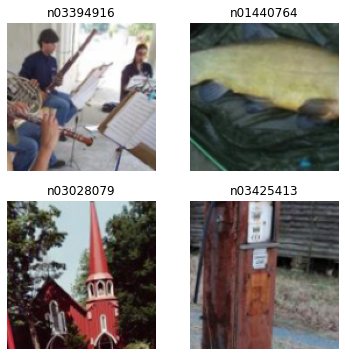

In [68]:
dls.show_batch(max_n=4)

In [69]:
def avg_pool(x): return x.mean((2,3))

In [70]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [71]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.004365158267319202)

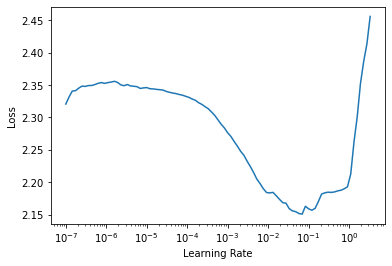

In [72]:
learn.lr_find()

In [73]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.889821,1.786824,0.381146,00:07
1,1.508686,1.381560,0.545732,00:06
2,1.280121,1.401667,0.542420,00:06
3,1.132843,1.109630,0.651465,00:06
4,1.038367,1.040462,0.667006,00:07


## Building a Modern CNN: ResNet

### Skip Connections

In [74]:
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni,nf),
            ConvLayer(nf,nf, norm_type=NormType.BatchZero))
        
    def forward(self, x): return x + self.convs(x)

In [75]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

In [76]:
class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [77]:
def block(ni,nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())

In [78]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.995549,1.857871,0.339108,00:08
1,1.692688,1.702599,0.437452,00:08
2,1.426178,1.318322,0.576815,00:08
3,1.217574,1.126176,0.639745,00:08
4,1.095231,1.064523,0.667771,00:08


In [79]:
def block(ni, nf):
    return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

In [80]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.974333,1.962906,0.339618,00:09
1,1.623804,1.400905,0.542930,00:10
2,1.343145,1.248982,0.602548,00:10
3,1.111588,1.023854,0.672866,00:10
4,0.963552,0.958986,0.694013,00:10


### A State-of-the-Art ResNet

In [81]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

In [82]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [83]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))
    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

In [84]:
rn = ResNet(dls.c, [2,2,2,2])

In [85]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.716316,2.197104,0.339108,00:14
1,1.331992,1.703405,0.492994,00:13
2,1.075089,1.090488,0.636433,00:13
3,0.876260,0.828821,0.733503,00:13
4,0.756113,0.762310,0.753121,00:13


### Bottleneck Layers

In [86]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf//4, 1),
        ConvLayer(nf//4, nf//4, stride=stride), 
        ConvLayer(nf//4, nf, 1, act_cls=None, norm_type=NormType.BatchZero))

In [87]:
dls = get_data(URLs.IMAGENETTE_320, presize=320, resize=224)

A new version of this dataset is available, downloading...


In [88]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [89]:
learn = get_learner(rn)
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.656000,1.607494,0.474650,01:24
1,1.407172,1.518101,0.494777,01:17
2,1.268693,2.303601,0.381911,01:17
3,1.165992,1.442706,0.545987,01:18
4,1.017503,2.917216,0.476178,01:18
5,0.928644,2.347678,0.462166,01:18
6,0.852995,0.927936,0.701401,01:17
7,0.762810,2.619455,0.414268,01:18
8,0.701464,2.248425,0.578853,01:18
9,0.640721,1.390768,0.616306,01:18


KeyboardInterrupt: 